# Quantum Volume

The quantum volume is a holistic quantum computer performance measure [QVOL0, QVOL1, QVOL2].


Roughly the logarithm (base 2) of quantum volume $V_Q$, quantifies the largest random circuit of equal width and depth that the computer successfully implements and is certifiably quantum.

So if you have 64 qubits and the best log-QV you have measured is $\log_2V_Q = 3$ then effectively you only have a 3 qubit device!



The quantum volume metric accounts for all relevant hardware parameters, e.g.

* coherence
* calibration errors
* crosstalk 
* spectator errors
* gate fidelity, measurement fidelity, initialization fidelity
* qubit connectivity 
* gate set

## Some details

A circuit that measures the quantum volume consists of layers of  a permutations of $n$ qubits followed by nearest neighbor two qubit Haar random unitaries. At the end we measure in the computational basis. See Figure 1.

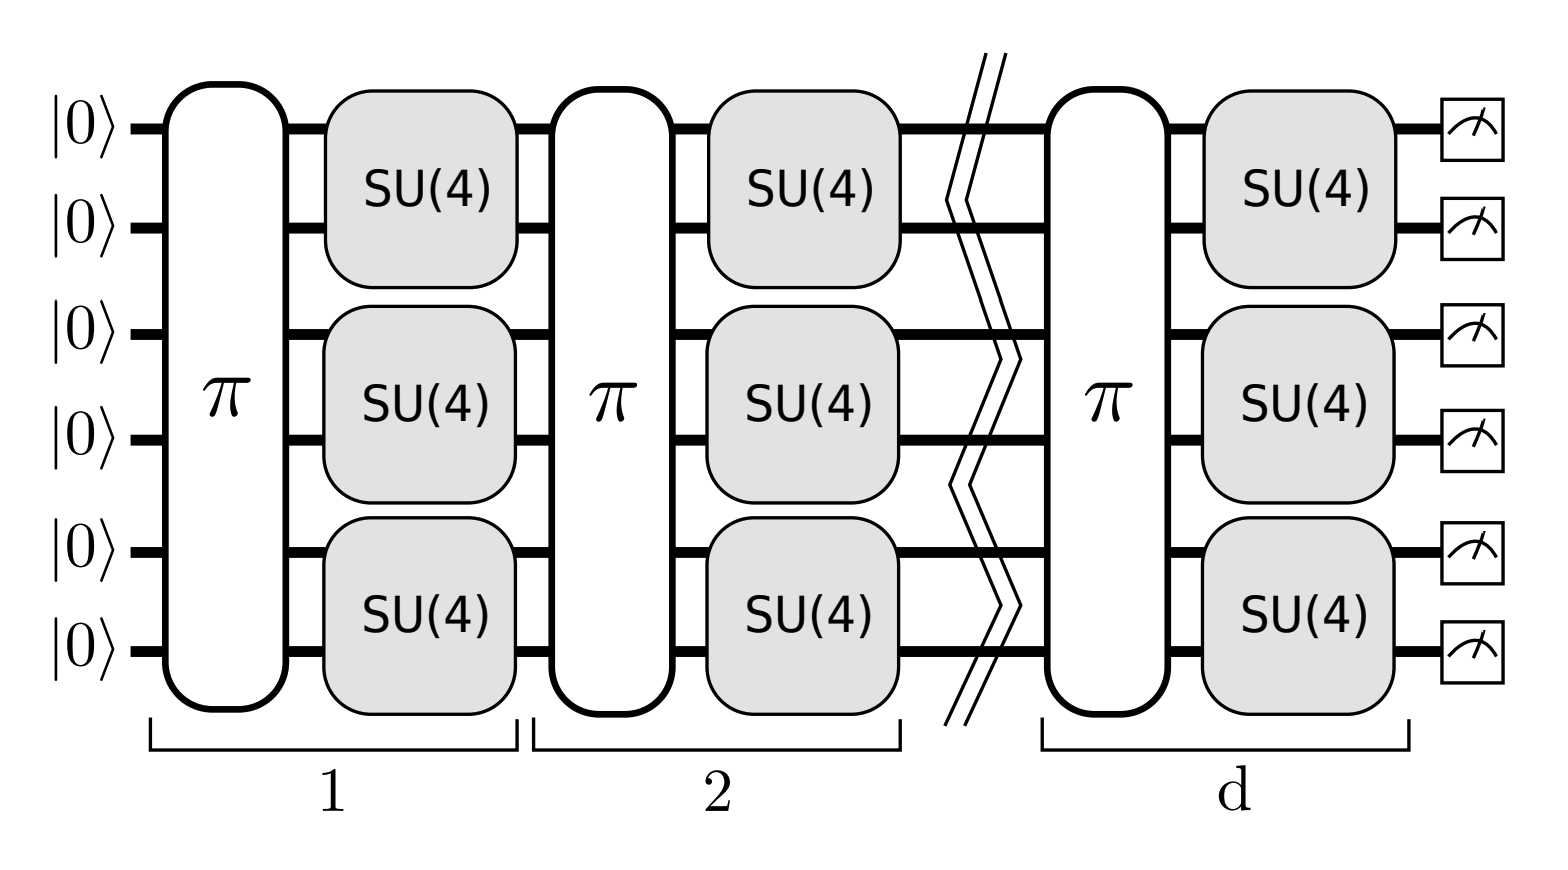
Figure 1. from [Cross et al.](https://arxiv.org/abs/1811.12926) [QVOL0].

A circuit to measure the quantum volume consists of a permutation gate on $n$ qubits denoted by $\pi$ in the above figure. The gate ${\rm SU}(4)$ denotes are two qubit gate drawn from the Haar measure on the [special unitary group](https://en.wikipedia.org/wiki/Special_unitary_group) of degree 4.
    
The certification of quantumness comes from the so called **Heavy Output Generation** problem and the **Quantum Threshold Assumption** see [HOG] for more details.

| [QVOL0] *Validating quantum computers using randomized model circuits.*  
|     Cross et al.  
|     arXiv:1811.12926 (2018).  
|     https://arxiv.org/abs/1811.12926  

| [QVOL1] *Quantum optimization using variational algorithms on near-term quantum devices.*  
|     Moll et al.  
|     Quantum Science and Technology 3, Number 3 2018.  
|     https://doi.org/10.1088/2058-9565/aab822  
|     https://arxiv.org/abs/1710.01022  

| [QVOL2] *Quantum Volume.*  
|     Bishop et al.  
|     (2017).  
|     https://ibm.co/2NdyRvf  

| [HOG] *Complexity-Theoretic Foundations of Quantum Supremacy Experiments.*  
|     Aaronson and Chen.  
|     32nd Computational Complexity Conference, vol 79 (CCC 2017).  
|     https://doi.org/10.4230/LIPIcs.CCC.2017.22  
|     https://arxiv.org/abs/1612.05903  

Some imports, get noisy and ideal QVM

In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
show_progress_bar = True

from pyquil.api import get_qc

The qubits we will run on are [0, 1, 2, 3]


/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


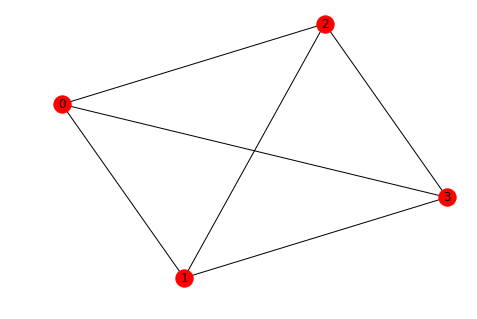

In [3]:
ideal_qc = get_qc('4q-qvm', noisy=False)
noisy_qc = get_qc("4q-noisy-qvm", noisy=True)

qubits = ideal_qc.qubits()
print('The qubits we will run on are', qubits)
graph = ideal_qc.qubit_topology()
nx.draw(graph, with_labels=True)

## Measure the quantum volume

Here we will replicate Figure 2. of [QVOL0].


### Start with the noiseless QVM

Caution, this is SLOW--it takes about 4 minutes.

In [4]:
from forest.benchmarking.quantum_volume import measure_quantum_volume

In [5]:
ideal_outcomes = measure_quantum_volume(ideal_qc, num_circuits=200, show_progress_bar=show_progress_bar)

100%|██████████| 200/200 [03:42<00:00,  1.08s/it]


### Now use a noisy QVM

This is SLOW--it takes about 5 minutes, even with half the number of shots from above.

In [6]:
noisy_outcomes = measure_quantum_volume(noisy_qc, num_circuits=200, num_shots=500, show_progress_bar=show_progress_bar)

100%|██████████| 200/200 [03:21<00:00,  1.01it/s]


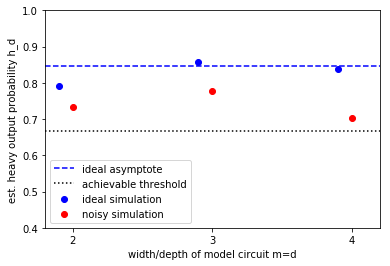

In [7]:
depths = np.arange(2, 5)
ideal_probs = [ideal_outcomes[depth][0] if depth in ideal_outcomes.keys() else 0 for depth in depths]
noisy_probs = [noisy_outcomes[depth][0] if depth in noisy_outcomes.keys() else 0 for depth in depths]

plt.axhline(.5 + np.log(2)/2, color='b', ls='--', label='ideal asymptote')
plt.axhline(2/3, color='black', ls=':', label='achievable threshold')
plt.scatter(np.array(depths) - .1, ideal_probs, color='b', label='ideal simulation')
plt.scatter(depths, noisy_probs, color='r', label='noisy simulation')
plt.ylabel("est. heavy output probability h_d")
plt.xlabel("width/depth of model circuit m=d")
plt.ylim(.4,1.0)
plt.xlim(1.8, 4.2)
plt.xticks(depths)
plt.legend(loc='lower left')
plt.show()

### Use a QVM with different topologies

As explained in the references [QVOL0, QVOL1, QVOL2] the quantum volume is topology (or qubit connectivity) dependent. Here we show how to explore that dependence on the QVM.

In [8]:
n = 4
path_graph = nx.path_graph(n)
loop_graph = nx.cycle_graph(n)
four_pointed_star = nx.star_graph(n)

/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


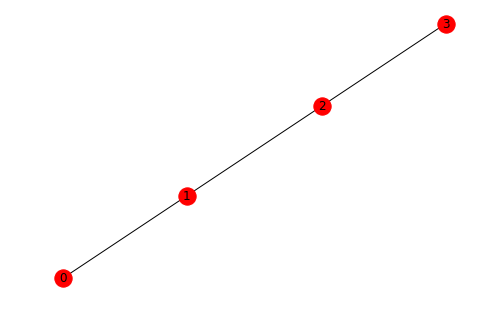

In [9]:
nx.draw(path_graph, with_labels=True)

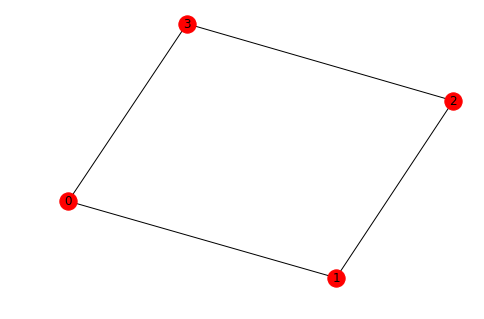

In [10]:
nx.draw(loop_graph, with_labels=True)

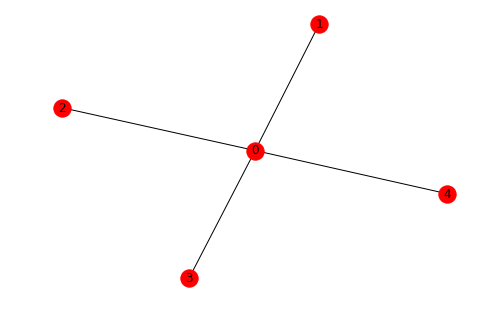

In [11]:
nx.draw(four_pointed_star, with_labels=True)

In [12]:
from pyquil.api._quantum_computer import _get_qvm_with_topology
path_qc = _get_qvm_with_topology(name='path', topology=path_graph, noisy=True)

In [13]:
path_outcomes = measure_quantum_volume(path_qc, num_circuits=200, num_shots=500, show_progress_bar=show_progress_bar)

100%|██████████| 200/200 [03:53<00:00,  1.18s/it]


### Compare to noisy complete topology

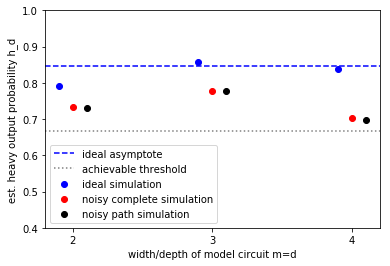

In [14]:
depths = np.arange(2, 5)
ideal_probs = [ideal_outcomes[depth][0] if depth in ideal_outcomes.keys() else 0 for depth in depths]
noisy_probs = [noisy_outcomes[depth][0] if depth in noisy_outcomes.keys() else 0 for depth in depths]
path_probs = [path_outcomes[depth][0] if depth in path_outcomes.keys() else 0 for depth in depths]

plt.axhline(.5 + np.log(2)/2, color='b', ls='--', label='ideal asymptote')
plt.axhline(2/3, color='grey', ls=':', label='achievable threshold')
plt.scatter(np.asarray(depths) - .1, ideal_probs, color='b', label='ideal simulation')
plt.scatter(depths, noisy_probs, color='r', label='noisy complete simulation')
plt.scatter(np.asarray(depths) + .1, path_probs, color='black', label='noisy path simulation')
plt.ylabel("est. heavy output probability h_d")
plt.xlabel("width/depth of model circuit m=d")
plt.ylim(.4,1.0)
plt.xlim(1.8, 4.2)
plt.xticks(depths)
plt.legend(loc='lower left')
plt.show()

## Run intermediate steps yourself

In [15]:
from forest.benchmarking.quantum_volume import generate_abstract_qv_circuit, _naive_program_generator, collect_heavy_outputs
from pyquil.numpy_simulator import NumpyWavefunctionSimulator
from pyquil.gates import RESET
import time

def generate_circuits(depths):
    for d in depths:
        yield generate_abstract_qv_circuit(d)

def convert_ckts_to_programs(qc, circuits, qubits=None):
    for idx, ckt in enumerate(circuits):
        if qubits is None:
            d_qubits = qc.qubits()  # by default the program can act on any qubit in the computer
        else:
            d_qubits = qubits[idx]

        yield _naive_program_generator(qc, d_qubits, *ckt)


def acquire_quantum_volume_data(qc, programs, num_shots = 1000, use_active_reset = False):
    for program in programs:
        start = time.time()

        if use_active_reset:
            reset_measure_program = Program(RESET())
            program = reset_measure_program + program

        # run the program num_shots many times
        program.wrap_in_numshots_loop(num_shots)
        executable = qc.compiler.native_quil_to_executable(program)

        results = qc.run(executable)

        runtime = time.time() - start
        yield results


def acquire_heavy_hitters(abstract_circuits):
    for ckt in abstract_circuits:
        perms, gates = ckt
        depth = len(perms)
        wfn_sim = NumpyWavefunctionSimulator(depth)

        start = time.time()
        heavy_outputs = collect_heavy_outputs(wfn_sim, perms, gates)
        runtime = time.time() - start

        yield heavy_outputs


Generate (len(unique_depths) x n_circuits) many "Abstract Ckt"s that describe each model circuit for each depth.

In [16]:
n_circuits = 100
unique_depths = [2,3]
depths = [d for d in unique_depths for _ in range(n_circuits)]
ckts = list(generate_circuits(depths))
print(ckts[0])

([array([0, 1]), array([0, 1])], array([[[[-0.55144177-0.26647286j,  0.25608208-0.41848682j,
           0.55437382+0.11126989j, -0.24805162+0.05435086j],
         [ 0.41850421-0.03852132j, -0.53379603-0.51061081j,
           0.26404218+0.40033292j,  0.15801984-0.15084347j],
         [-0.40802791+0.31687703j,  0.01503824+0.24504135j,
           0.17852483+0.25917974j,  0.57633624-0.49155065j],
         [-0.37207091-0.20721954j, -0.28645198-0.26702623j,
          -0.59009825-0.05516123j, -0.24902407-0.5019899j ]]],


       [[[ 0.0721541 +0.2574555j ,  0.44139907+0.09559298j,
           0.32209343+0.1954255j , -0.75505192-0.11180601j],
         [-0.04215926+0.38005476j, -0.80331064+0.15558321j,
           0.12962856+0.19247929j, -0.25682973+0.25387694j],
         [ 0.41663853+0.49404772j, -0.10656293-0.23819313j,
           0.2316722 -0.47365229j,  0.16001332-0.45892787j],
         [-0.52792383+0.29311608j,  0.09861876+0.22067494j,
          -0.34666698-0.63719413j, -0.19454456+0.1136413

Use the _naive_program_generator to synthesize native pyquil programs that implement each ckt natively on the qc.

In [17]:
progs = list(convert_ckts_to_programs(noisy_qc, ckts))
print(progs[0])

DEFGATE LYR0_RAND0:
    -0.5514417662847406-0.26647286492053557i, 0.2560820842110857-0.41848681651537906i, 0.5543738175381981+0.1112698861629722i, -0.24805162392092533+0.054350859591478944i
    0.4185042068735709-0.03852132265800101i, -0.5337960273567897-0.5106108058052399i, 0.2640421819713798+0.4003329203692477i, 0.15801984183607665-0.15084346620705238i
    -0.408027909392624+0.31687703157097785i, 0.015038238995869325+0.24504135402018049i, 0.17852483272191516+0.2591797410324012i, 0.576336243741776-0.49155064672617377i
    -0.3720709110190956-0.20721953667663526i, -0.2864519762799716-0.2670262312865932i, -0.5900982511275752-0.0551612348120724i, -0.2490240699384845-0.5019899029508219i

DEFGATE LYR1_RAND0:
    0.07215410056104908+0.2574554986668327i, 0.4413990745932045+0.09559298457773703i, 0.3220934299476927+0.1954255019946097i, -0.7550519199163047-0.11180601062380173i
    -0.042159261292436585+0.3800547644756522i, -0.8033106407885078+0.1555832106222027i, 0.12962856172382972+0.192479287

Run the programs. This can be slow.

In [18]:
num_shots=10
results = list(acquire_quantum_volume_data(noisy_qc, progs, num_shots=num_shots))

Classically simulate the circuits to get heavy hitters, and record how many hh were sampled for each program run.

In [19]:
ckt_hhs = acquire_heavy_hitters(ckts)

Count the number of heavy hitters that were sampled on the qc

In [20]:
from forest.benchmarking.quantum_volume import count_heavy_hitters_sampled
num_hh_sampled = count_heavy_hitters_sampled(results, ckt_hhs)

Get estimates of the probability of sampling hh at each depth, and the lower bound on that estimate

In [21]:
from forest.benchmarking.quantum_volume import get_prob_sample_heavy_by_depth

results = get_prob_sample_heavy_by_depth(depths, num_hh_sampled, [num_shots for _ in depths])
results

{2: (0.721, 0.6312984949959032), 3: (0.774, 0.6903521667943515)}

Use the results to get a lower bound on the quantum volume

In [22]:
from forest.benchmarking.quantum_volume import extract_quantum_volume_from_results
qv = extract_quantum_volume_from_results(results)
qv

2